In [15]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os
from sklearn.metrics import *
from skimage.io import imread
from skimage import io
import pandas as pd

In [23]:
def plot_comparison(original, filtered, filter_name):
    font2 = {'family':'serif','color':'black','size':20}
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('True segmentation',fontdict = font2)
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name,fontdict = font2)
    ax2.axis('off')

# Data Neurite

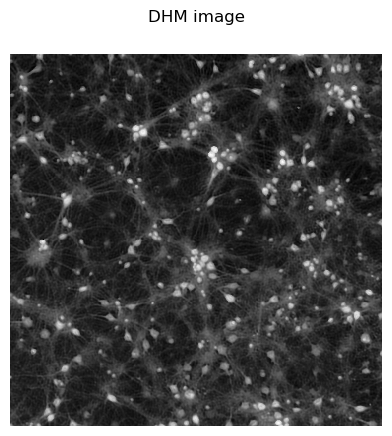

()
(800, 800)


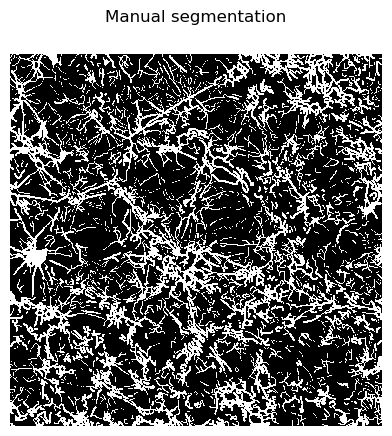

(800, 800)
(800, 800)


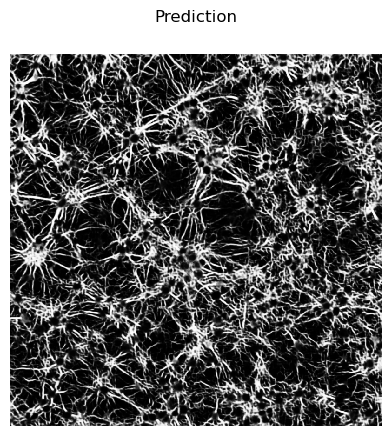

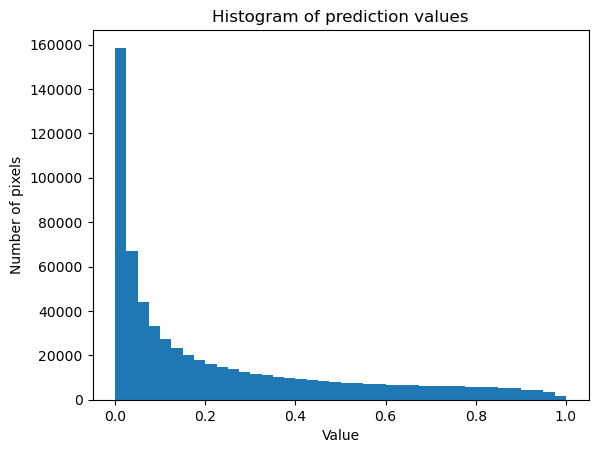

In [16]:
# Original image

DHM = imread('/Users/behnaz/NCADD/prediction_cell_neurite/img/2022_08_09_D12_CS2_7_5X.tif')

plt.matshow(DHM)
plt.set_cmap('Greys_r')
plt.title('DHM image')
plt.axis('off')
plt.show()


# Ground truth

tif = tifffile.TiffFile('/Users/behnaz/NCADD/prediction_cell_neurite/img/MAX_Rec_BS_2022_08_09_D12_CS2_Mask.tif')
print(np.shape(tif))
data = tif.pages[0].asarray().astype('double') #Double-precision floating-point number type
print(np.shape(data ))
truth = data/data.max() # Normalization

truth_bin = (truth>0).astype(int) #convert to binary image

plt.matshow(truth)
plt.set_cmap('Greys_r')
plt.title('Manual segmentation')
plt.axis('off')
plt.show()


# Prediction

image = imread('/Users/behnaz/NCADD/prediction_cell_neurite/img/2022_08_09_D12_CS2_7_5X_probability_map.tif')
print(np.shape(image ))
image = image.astype('double')
print(np.shape(image ))
prediction = image/image.max()


plt.matshow(prediction)
plt.set_cmap('Greys_r')
plt.title('Prediction')
plt.axis('off')
plt.show()

plt.hist(prediction.flatten(),40) #Return a copy of the array collapsed into one dimension.
plt.title('Histogram of prediction values')
plt.xlabel('Value')
plt.ylabel('Number of pixels')
plt.show()


# Receiver operating characteristics

462930 177070
(640000,)
(640000,)
[0.31813328 0.40486489 0.53092206 ... 0.03163591 0.01864659 0.03122842] [0 0 0 ... 0 0 0]
AveP = 0.7658987947829888
AUC = 0.8986261865018675
[0.         0.         0.         ... 0.99994384 0.99994816 1.        ] [0.00000000e+00 5.64748405e-06 1.18597165e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [2.00000000e+00 1.00000000e+00 9.98349730e-01 ... 9.47048091e-05
 9.38336556e-05 5.33248924e-05]
[0.30159667 0.30159784 0.30162106 ... 0.30160822 0.30160734 0.30159667]


/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2990/3814552098.py:37: RuntimeWarning: divide by zero encountered in divide
  P = TP/(TPR) #array of possitive, convert it to this scale to find max number of possitive
/var/folders/0c/_vv7vm4n5z33nmfk83_ct2480000gn/T/ipykernel_2990/3814552098.py:46: RuntimeWarning: divide by zero encountered in divide
  N = TN/(TNR)   #array of negative, convert it to this scale to find max number of negative


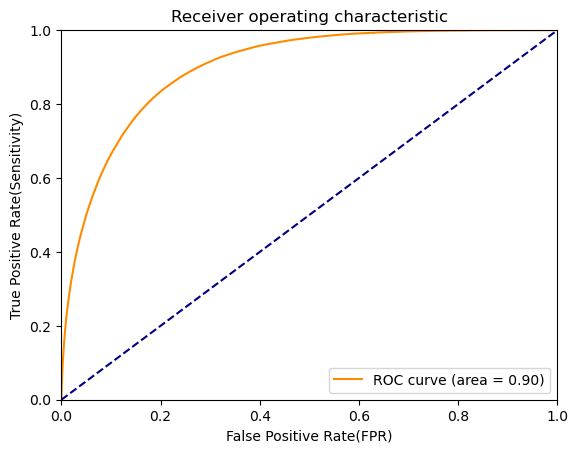

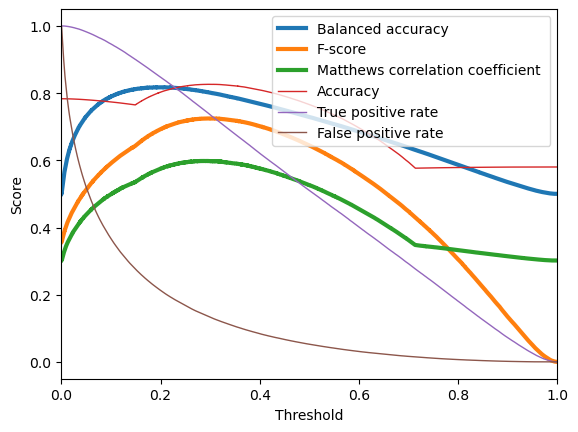

In [17]:
true = truth_bin.flatten() #Flatten binary mask, then it has two parts, part one with value=0 and part two with value=1
#plt.hist(true)
max_number = true.shape[0] # Max value for true positives and true negatives (len(true))
#print(max_number)
TP = np.sum(true>0) # True positives (neurites)

TN = np.sum(true==0) # True negatives (background)
print(TN,TP)
scores = prediction.flatten() #model prediction (model prediction (non-binary) but true should be binary)
# Check shapes of true and scores
print(true.shape)
print(scores.shape)

if true.shape != scores.shape:
    raise ValueError("Input arrays have different shapes")

print(scores, true)
AveP = average_precision_score(true, scores)  #Compute average precision (AP) from prediction scores.
print('AveP = ' + str(AveP))

AUC = roc_auc_score(true, scores)  #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
print('AUC = ' + str(AUC))


# False positive rates, True positive rates, and thresholds
FPR, TPR, thr = roc_curve(true, scores)
print(FPR,TPR,thr)
size = len(thr)

# True negative rates
TNR = 1-FPR

# False negative rates
FNR = 1-TPR

# Positives
P = TP/(TPR) #array of possitive, convert it to this scale to find max number of possitive
#print(TPR[100],P[100])

for i in range(size):
    if P[i]>max_number:
        P[i]=max_number
        

# Negatives
N = TN/(TNR)   #array of negative, convert it to this scale to find max number of negative
for i in range(size):
    if N[i]>max_number:
        N[i]=max_number
        

# False postives
FP = N*(FPR.flatten())
#print(np.sum(FP.flatten()>0))

# False negatives
FN = P*FNR


# Positive prediction values (precision)
PPV = TP/(TP+FP)

# F scores
Fscore = 2*PPV*TPR/(PPV+TPR)

# Accurary
ACC = (TP+TN)/(P+N) 

# Balanced accuracy
BA = (TPR+TNR)/2

# Matthews correlation coefficient 
MCC = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print(MCC)

plt.figure()
plt.plot(
    FPR,
    TPR,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % AUC
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
#plt.savefig('ROC.png')
plt.show()

plt.plot(thr,BA,linewidth = 3.0)
plt.plot(thr,Fscore,linewidth = 3.0)
plt.plot(thr,MCC,linewidth = 3.0)
plt.plot(thr,ACC,linewidth = 1.0)
plt.plot(thr,TPR,linewidth = 1.0)
plt.plot(thr,FPR,linewidth = 1.0)
#plt.plot(thr,TNR)
#plt.plot(thr,FNR)
plt.xlim(0.0, 1.0)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(['Balanced accuracy','F-score', 'Matthews correlation coefficient ',
            'Accuracy','True positive rate', 'False positive rate'])
#plt.savefig('allmeasures.png')
plt.show()

### Optimal threshold based on F-score

Threshod selected: 0.29604649519629045


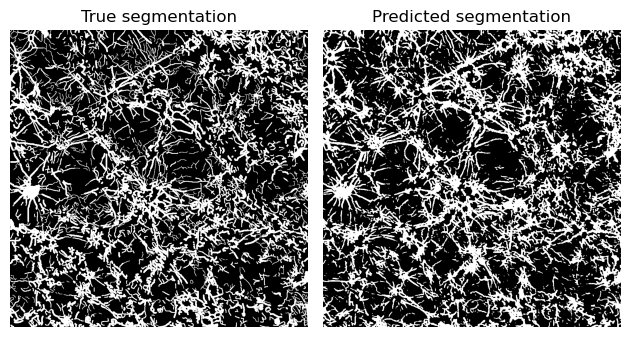

              precision    recall  f1-score   support

 non-neurite       0.90      0.86      0.88    462930
     neurite       0.68      0.74      0.71    177070

    accuracy                           0.83    640000
   macro avg       0.79      0.80      0.79    640000
weighted avg       0.84      0.83      0.83    640000



In [19]:
# Position of max F-score
#id = np.argmax(BA)
id_thr = np.argmax(Fscore)
op_thr = thr[id_thr]
print('Threshod selected: ' + str(op_thr))

# Binarized prediction
prediction_bin = (prediction>op_thr).astype(int)
#prediction_bin = prediction_bin.reshape(image.shape[:-1])
#io.imsave('U_Neurite_Avrg_Bw_5X_5_max_0.2_F_score.png',prediction_bin)

# Display result
f = plt.figure()

f.add_subplot(1,2, 1)
plt.imshow(truth_bin)
plt.title('True segmentation')
plt.axis('off')

f.add_subplot(1,2,2)
plt.imshow(prediction_bin)
plt.title('Predicted segmentation')
plt.axis('off')

plt.tight_layout()
plt.show()

# Report on classification for optimal threshold 
target_names = ['non-neurite', 'neurite']
print(classification_report(truth_bin.flatten(), prediction_bin.flatten(), target_names=target_names))
report= classification_report(truth_bin.flatten(), prediction_bin.flatten(), target_names=target_names)

### Optimal threshold based on Balanced accuracy

Threshod selected: 0.09090909090909091
              precision    recall  f1-score   support

 non-neurite       0.97      0.61      0.75    462930
     neurite       0.48      0.95      0.64    177070

    accuracy                           0.71    640000
   macro avg       0.73      0.78      0.70    640000
weighted avg       0.84      0.71      0.72    640000



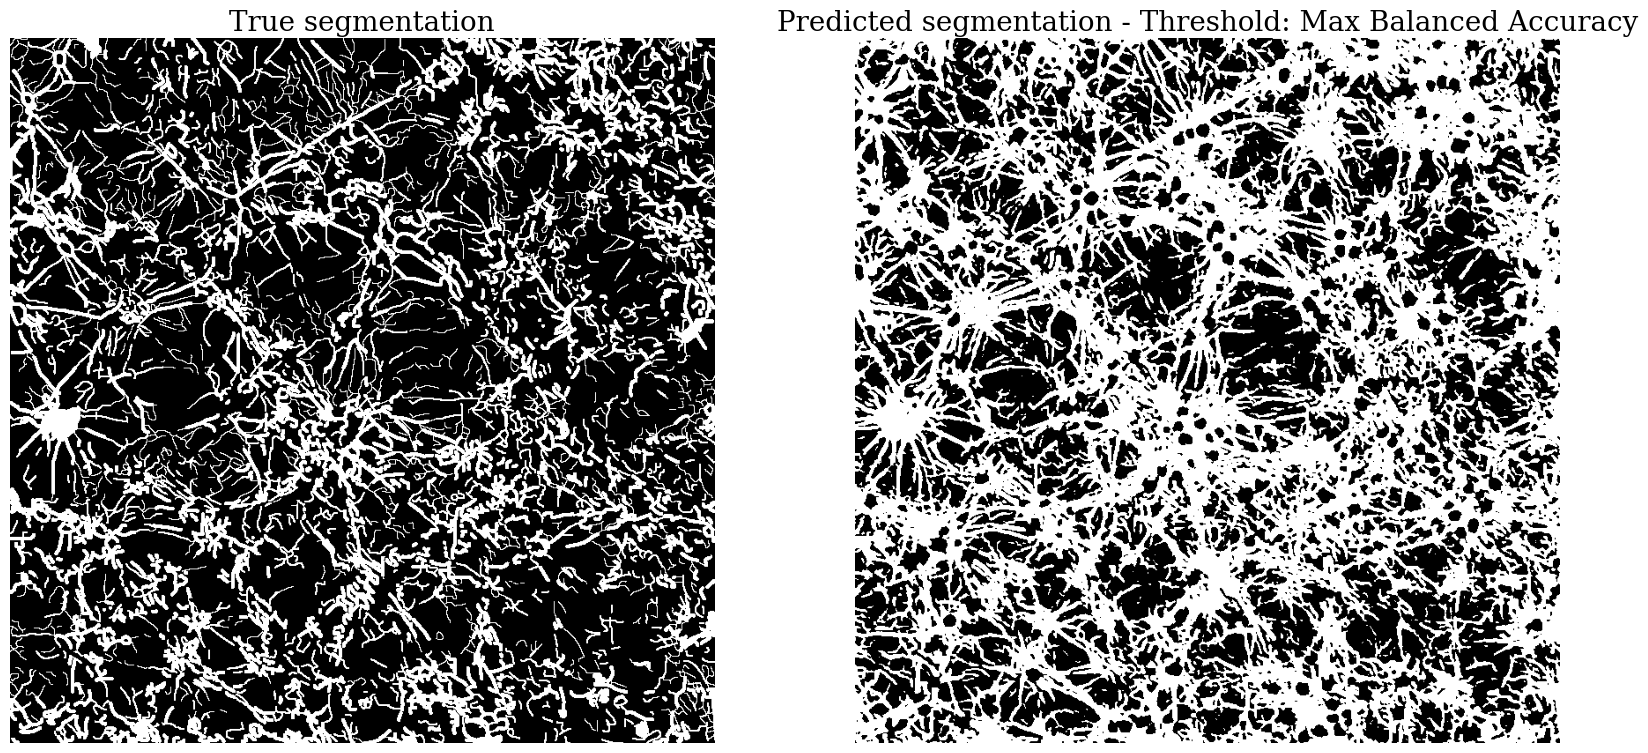

In [22]:

# Position of max F-score
#id = np.argmax(BA)
id_thr = np.argmax(BA)
op_thr =0.09090909090909091 #thr[id_thr]    Optimal Threshod selected (BA): 
print('Threshod selected: ' + str(op_thr))

# Binarized prediction
prediction_bin = ((prediction>op_thr).astype(int))
#prediction_bin = prediction_bin.reshape(image.shape[:-1])
#io.imsave('U_Neurite_2023_01_18_D5_CS5_666_Bw_2_5X_BA.png',prediction_bin)

# Display result
# Display result
plot_comparison(truth_bin, prediction_bin, 'Predicted segmentation - Threshold: Max Balanced Accuracy')
#plt.savefig('Large_Nerite_thr.png')

# Report on classification for optimal threshold 
target_names = ['non-neurite', 'neurite']
print(classification_report(truth_bin.flatten(), prediction_bin.flatten(), target_names=target_names))